In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')
import corner
from tqdm.auto import tqdm  # notebook friendly
import glob
import arviz as az

from agnfinder.prospector.main import load_catalog
from agnfinder.prospector import load_photometry
from agnfinder import simulation_samples, simulation_utils
from agnfinder.tf_sampling import parameter_recovery, percentile_limits, hmc

In [3]:
from scipy import stats

In [4]:
os.chdir('/home/walml/repos/agnfinder')

### Let's have a go with fake data to develop the algorithm

In [5]:
def truncated_normal_samples(mu, std, n_samples=1000): # 0->1 range
    min_val = 0.
    max_val = 1.
    a, b = (min_val - mu) / std, (max_val - mu) / std
    return stats.truncnorm(a, b, loc=mu, scale=std).rvs(n_samples)

In [6]:
n_galaxies = 1000
mu = np.linspace(0.1, 0.9, n_galaxies)
std = 0.05
true_values = np.array([truncated_normal_samples(x, std, n_samples=1) for x in mu]).squeeze()
posteriors = np.array([truncated_normal_samples(x, std) for x in mu])
true_values.shape, posteriors.shape

((1000,), (1000, 1000))

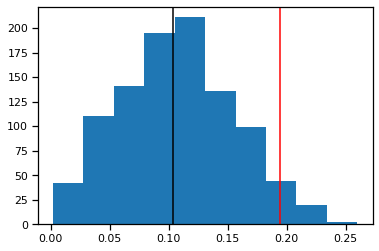

In [7]:
n = 5
plt.hist(posteriors[n, :])
plt.axvline(mu[n], color='k')
plt.axvline(true_values[n], color='r')


In [8]:
def get_hpd(x, ci=0.8):  # TODO assumes a clear MLE exists - should throw error if not
    if len(x) == 0:
        return np.array([np.nan, np.nan])
#     https://arviz-devs.github.io/arviz/generated/arviz.hpd.html
    return az.hpd(x[~np.isnan(x)], credible_interval=ci, multimodal=True)  # may return multiple ci's for multiple modes

[[0.05057837 0.41222052]
 [0.58801878 0.96472935]]


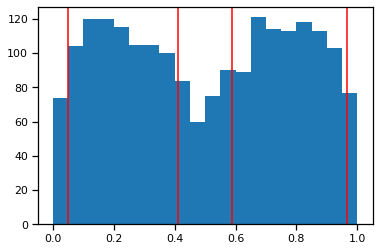

In [9]:
multimodal_samples = np.concatenate([truncated_normal_samples(0.2, 0.2, 1000), truncated_normal_samples(0.8, 0.2, 1000)])
modes = get_hpd(multimodal_samples)
print(modes)
plt.hist(multimodal_samples, bins=20)
for mode in modes:
    plt.axvline(mode[0], color='r')
    plt.axvline(mode[1], color='r')

In [10]:
def get_coverage(posteriors, true_values):
    results = []
    for ci_width in np.linspace(0.1, 0.95):
        for target_n, posterior in enumerate(posteriors):
            true_value = true_values[target_n]
            credible_interval_width = 0.8
            modes = get_hpd(posterior, ci=ci_width)
            within_any_ci = any([x[0] < true_value < x[1] for x in modes])
            results.append({
                'ci_width': ci_width,
#                 'hpd_min': hpd[0],
#                 'hpd_max': hpd[1],
                'true_value': true_value,
                'true_within_hpd': within_any_ci
            })
    return pd.DataFrame(results)

In [11]:
df = get_coverage(posteriors, true_values)
df.head()

,ci_width,true_value,true_within_hpd
0,0.1,0.021107,False
1,0.1,0.194928,False
2,0.1,0.186214,False
3,0.1,0.021976,False
4,0.1,0.158728,False


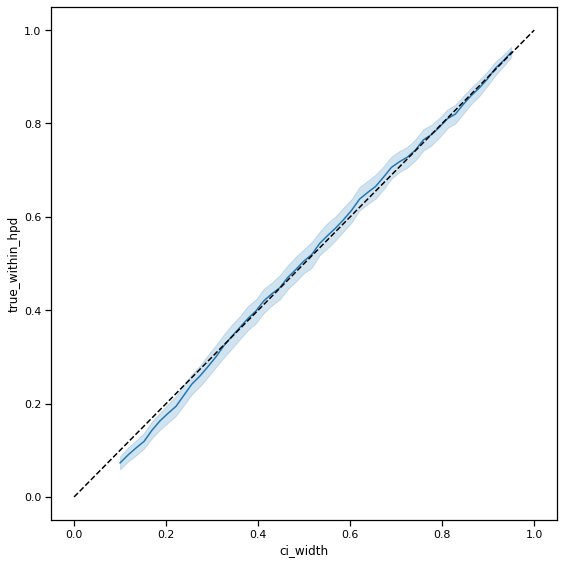

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=df, x='ci_width', y='true_within_hpd', ax=ax, ci=90)
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below

In [13]:
def get_error_coverage(posteriors, true_values):
    results = []
    for error in np.linspace(0.01, 0.2):
        for obs_n, posterior in enumerate(posteriors):
            # simply to check unimodal
            modes = get_hpd(posterior)
            if len(modes) > 1:
                continue  # skip multimodal
            best_guess = np.median(posterior)
            lower_lim = np.max([0, best_guess - error])
            upper_lim = np.min([1, best_guess + error])
            assert lower_lim <= upper_lim
            posterior_frac = np.mean((lower_lim <= posterior) & (posterior <= upper_lim))
            true_is_within = lower_lim < true_values[obs_n] < upper_lim
            results.append(
                {
                    'error': error,
                    'lower_lim': lower_lim,
                    'best_guess': best_guess,
                    'posterior_frac': posterior_frac,
                    'true_is_within': true_is_within
                }
            )
    return pd.DataFrame(results)

In [14]:
error_df = get_error_coverage(posteriors, true_values)

In [15]:
error_df.head()

,error,lower_lim,best_guess,posterior_frac,true_is_within
0,0.01,0.091464,0.101464,0.156,False
1,0.01,0.093001,0.103001,0.144,False
2,0.01,0.095091,0.105091,0.171,False
3,0.01,0.094174,0.104174,0.158,False
4,0.01,0.094018,0.104018,0.162,False


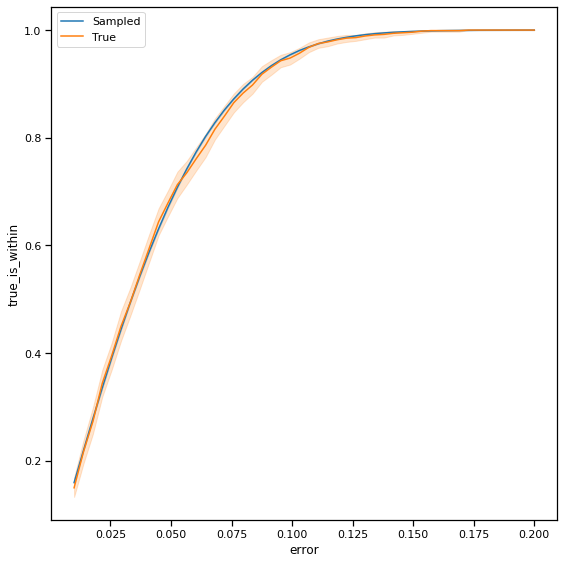

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.lineplot(data=error_df, x='error', y='posterior_frac', ax=ax, ci=90, label='Sampled')
sns.lineplot(data=error_df, x='error', y='true_is_within', ax=ax, ci=90, label='True')
# ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()
# This the same as my manual version below

In [17]:
# courtesy of http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)


In [18]:
def aggregate_coverage_df(df):
    temp = df.copy()
    # duplicate the useful column, use one copy for the uncertainty
    temp['observed_rate'] = temp['true_within_hpd']
    temp['observed_rate_unc'] = temp['true_within_hpd']
    coverage = temp.groupby('ci_width').agg({'observed_rate': 'mean', 'observed_rate_unc': lambda x: bootstrap(x)(.9)}).reset_index()
    coverage['observed_rate_min'] = coverage['observed_rate_unc'].apply(lambda x: x[0])
    coverage['observed_rate_max'] = coverage['observed_rate_unc'].apply(lambda x: x[1])
    return coverage

In [19]:
def aggregate_error_coverage_df(df):
    temp = df.copy()
    # duplicate the useful column, use one copy for the uncertainty
    temp['posterior_frac_unc'] = temp['posterior_frac']
    coverage = temp.groupby('error').agg({'posterior_frac': 'mean', 'posterior_frac_unc': lambda x: bootstrap(x)(.9)}).reset_index()
    coverage['observed_rate_min'] = coverage['posterior_frac_unc'].apply(lambda x: x[0])
    coverage['observed_rate_max'] = coverage['posterior_frac_unc'].apply(lambda x: x[1])
    return coverage

In [20]:
coverage = aggregate_coverage_df(df)
coverage.head()

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


,ci_width,observed_rate,observed_rate_unc,observed_rate_min,observed_rate_max
0,0.100000,0.073,"(0.059, 0.087)",0.059,0.087
1,0.117347,0.090,"(0.076, 0.105)",0.076,0.105
2,0.134694,0.105,"(0.089, 0.122)",0.089,0.122
3,0.152041,0.119,"(0.102, 0.136)",0.102,0.136
4,0.169388,0.143,"(0.124, 0.162)",0.124,0.162


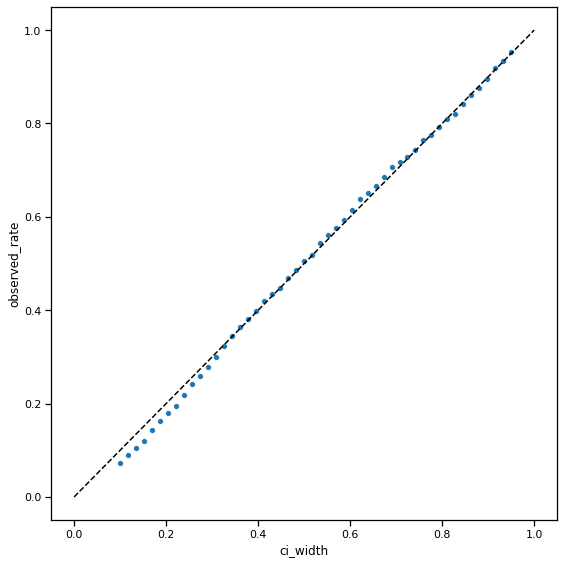

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=coverage, x='ci_width', y='observed_rate', ax=ax)
ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()

In [22]:
def plot_coverage(df):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(df['ci_width'], df['observed_rate'])
    ax.fill_between(x=df['ci_width'], y1=df['observed_rate_min'], y2=df['observed_rate_max'], alpha=0.5)
    ax.plot([0, 1.], [0, 1.], 'k--')
    fig.tight_layout()
    return fig, ax

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc2e8169c10>)

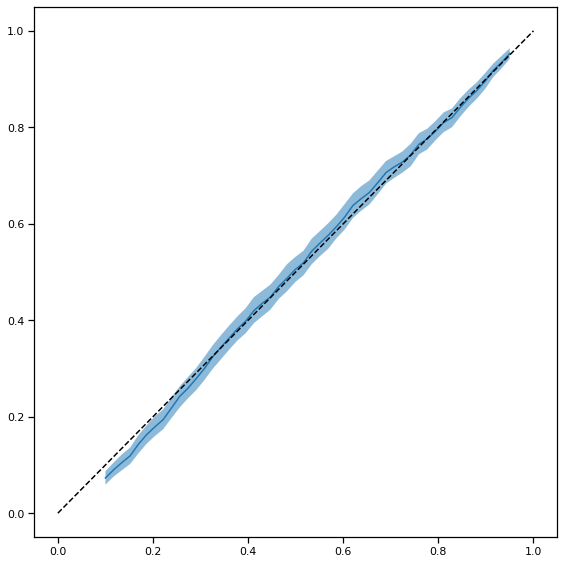

In [23]:
plot_coverage(coverage)

In [24]:
coverage = aggregate_error_coverage_df(error_df)
coverage.head()

 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:Mean of empty slice.
 /home/walml/anaconda3/envs/agnfinder/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:invalid value encountered in double_scalars


,error,posterior_frac,posterior_frac_unc,observed_rate_min,observed_rate_max
0,0.010000,0.159630,"(0.15900999999999998, 0.16025199999999998)",0.159010,0.160252
1,0.013878,0.219597,"(0.218887, 0.22027100000000002)",0.218887,0.220271
2,0.017755,0.278349,"(0.277659, 0.279053)",0.277659,0.279053
3,0.021633,0.335655,"(0.33492900000000003, 0.336422)",0.334929,0.336422
4,0.025510,0.391109,"(0.390337, 0.39187)",0.390337,0.391870


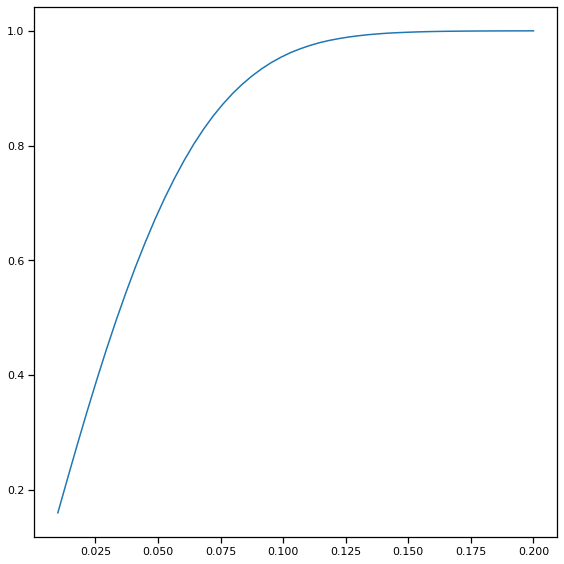

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(coverage['error'], coverage['posterior_frac'])
ax.fill_between(x=coverage['error'], y1=coverage['observed_rate_min'], y2=coverage['observed_rate_max'], alpha=0.5)
# ax.plot([0, 1.], [0, 1.], 'k--')
fig.tight_layout()

Coverage seems to work quite well with 1k galaxies, 1k samples, simple distribution, but tends towards mild overconfidence as the available data reduces. I wonder if this is expected?

In [26]:
# assert False

## Real galaxies

In [27]:
save_dir = 'results/emulated_sampling/latest_emcee_5000_10000_1_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_30000_16_optimised'
# save_dir = 'results/emulated_sampling/latest_hmc_10000_40000_16_optimised'

all_galaxy_locs = glob.glob(save_dir + '/galaxy*.h5')
assert all_galaxy_locs




In [28]:
# fig, axes = parameter_recovery.main(save_dir, use_filter=False, max_redshift=4.)

In [29]:
max_redshift = 4.0
n_param_bins = 50
n_posterior_bins = 50  # or will have to remake marginals

In [ ]:
params, marginals, true_params, samples = parameter_recovery.load_samples(save_dir, False, max_redshift)
len(samples), len(true_params)

121 galaxies loaded [00:00, 3797.91 galaxies loaded/s]
111 galaxies loaded [02:22,  1.42s/ galaxies loaded]

In [ ]:
if 'hmc' in save_dir:
    print('filtering')
    good_chains = [hmc.chains_pass_quality_check(x) for x in samples]
    samples = [x[:, good_chains[n]] for n, x in enumerate(samples)]
#     true_params = true_params[good_samples]  # can filter as np
else:
    print('Not filtering')

In [ ]:
samples[0].shape, samples[4].shape

In [ ]:
posteriors_all_params = [x.reshape(-1, 8) for x in samples]
del samples  # for memory

In [ ]:
def plot_all_coverages(posteriors_all_params_hmc, true_params_hmc, posteriors_all_params_emcee, true_params_emcee):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
    all_axes = [ax for row in axes for ax in row]
    params = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
    for param_n in range(8):
        ax = all_axes[param_n]
        ax.plot([0, 1.], [0, 1.], 'k--')
        ax.set_xlabel('Expected Rate')
        ax.set_ylabel('Observed Rate')
        ax.set_title(params[param_n])
        
        if posteriors_all_params_hmc is not None:
            subplot_coverage(posteriors_all_params_hmc, true_params_hmc, ax, param_n, label='hmc')
        if posteriors_all_params_emcee is not None:
            subplot_coverage(posteriors_all_params_emcee, true_params_emcee, ax, param_n, label='emcee')

    for ax_n, ax in enumerate(all_axes):
        if ax_n >= len(params):
            ax.remove()

    fig.legend(['Perfect', 'HMC', 'EM-NN'], loc=[0.78, 0.15])
    fig.tight_layout()
    fig.savefig('notebooks/inference/latest_coverage.pdf')

In [ ]:
def subplot_coverage(posteriors_all_params, true_params, ax, param_n, label):
        # select for param_n
        true_values = true_params[:, param_n]
        posteriors = [gal[:, param_n] for gal in posteriors_all_params]  # galaxy, samples (flat), params
        
        # filter as needed
        wide_enough = np.array([x.std() < 0.2 for x in posteriors])
        not_tiny = np.array([x.std() > 0.01 for x in posteriors])
#         good_width = wide_enough & not_tiny
        good_width = wide_enough
#         print(len(posteriors))
        posteriors = [x for n, x in enumerate(posteriors) if good_width[n]]
        true_values = true_values[wide_enough]
        
        print(len(posteriors))
#         print(len(true_values))
#         print(posteriors[0].shape)
        if len(posteriors) < 5:
            return None  # don't try to calculate coverage

        df = get_coverage(posteriors, true_values)
        coverage = aggregate_coverage_df(df)
        ax.plot(coverage['ci_width'], coverage['observed_rate'])
        ax.fill_between(x=coverage['ci_width'], y1=coverage['observed_rate_min'], y2=coverage['observed_rate_max'], alpha=0.5, label=label)
#         ax.legend()

In [ ]:
if 'hmc' in save_dir:
    posteriors_all_params_hmc = posteriors_all_params.copy()
    true_params_hmc = true_params.copy()
if 'emcee' in save_dir:
    posteriors_all_params_emcee = posteriors_all_params.copy()
    true_params_emcee = true_params.copy()
    
# posteriors_all_params_emcee = None
# true_params_emcee = None


In [ ]:
plot_all_coverages(posteriors_all_params_hmc, true_params_hmc, posteriors_all_params_emcee, true_params_emcee)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
all_axes = [ax for row in axes for ax in row]
all_axes[0].plot([0, 1])
fig.legend(['hello', 'world'], loc=[0.8, 0.2])

In [ ]:
# plot_all_coverages(posteriors_all_params_hmc, true_params_hmc, None, None)

In [ ]:
def plot_all_error_coverages(posteriors_all_params_hmc, true_params_hmc, posteriors_all_params_emcee, true_params_emcee):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8), sharex=True, sharey=True)
    all_axes = [ax for row in axes for ax in row]
    params = ['Stellar Mass', 'Dust', 'Age', 'Tau', 'AGN Disk Scale', 'AGN E(B-V)', 'AGN Torus Scale', 'AGN Torus Incl.']
    for param_n in range(8):
        ax = all_axes[param_n]
#         ax.plot([0, 1.], [0, 1.], 'k--')
        ax.set_title(params[param_n])
        
        if true_params_hmc is not None:
            plot_hmc(true_params_hmc, posteriors_all_params_hmc, ax, param_n)
        if true_params_emcee is not None:
            plot_emcee(true_params_emcee, posteriors_all_params_emcee, ax, param_n)

        ax.set_xlabel('Max Error')
        ax.set_ylabel('Truth Within Max Error')
# This the same as my manual version below
#         coverage = aggregate_coverage_df(df)
#         ax.plot(coverage['ci_width'], coverage['observed_rate'])
#         ax.fill_between(x=coverage['ci_width'], y1=coverage['observed_rate_min'], y2=coverage['observed_rate_max'], alpha=0.5)

    for ax_n, ax in enumerate(all_axes):
        if ax_n >= len(params):
            ax.remove()
    fig.tight_layout()

In [ ]:
def plot_hmc(true_params, posteriors_all_params, ax, param_n):
    # select for param_n
    true_values = true_params[:, param_n]
    posteriors = [gal[:, param_n] for gal in posteriors_all_params]  # galaxy, samples (flat), params

    print(len(posteriors))
    if len(posteriors) < 5:
        return None

    df = get_error_coverage(posteriors, true_values)
    sns.lineplot(data=df, x='error', y='true_is_within', ax=ax, ci=90, label='True')
    sns.lineplot(data=df, x='error', y='posterior_frac', ax=ax, ci=90, label='Expected (HMC)')
    

In [ ]:
def plot_emcee(true_params, posteriors_all_params, ax, param_n):
    # select for param_n
    true_values = true_params[:, param_n]
    posteriors = [gal[:, param_n] for gal in posteriors_all_params]  # galaxy, samples (flat), params

    # filter as needed TODO
    print(len(posteriors))
    if len(posteriors) < 5:
        return None  # don't try to calculate coverage

    df = get_error_coverage(posteriors, true_values)
    sns.lineplot(data=df, x='error', y='true_is_within', ax=ax, ci=90, label='True (EM-NN)')
#     sns.lineplot(data=df, x='error', y='posterior_frac', ax=ax, ci=90, label='Expected (EM-NN)')

In [ ]:
plot_all_error_coverages(
    posteriors_all_params_hmc=posteriors_all_params_hmc,
    true_params_hmc=true_params_hmc,
    posteriors_all_params_emcee=posteriors_all_params_emcee,
    true_params_emcee=true_params_emcee
)

In [ ]:
plot_all_error_coverages(
    posteriors_all_params_hmc=posteriors_all_params_hmc,
    true_params_hmc=true_params_hmc,
    posteriors_all_params_emcee=None,
    true_params_emcee=None
)

In [ ]:
posterior_records, param_bins = parameter_recovery.get_all_posterior_records(marginals, true_params, n_param_bins=n_param_bins, n_posterior_bins=n_posterior_bins)

In [ ]:
posterior_records[0].shape

In [ ]:
plt.plot(posterior_records[0][10])

In [ ]:
posterior_record = posterior_records[0]
posterior = posterior_record[20]
param_values = np.arange(len(posterior))


In [ ]:
samples.shape

In [ ]:
true_params[0, 0]

In [ ]:
az.hpd(samples[0, :, 0])

In [ ]:
# group samples wit

In [ ]:
dummy_array = np.zeros(42)  # anything
n_param_bins = 10
_, param_bins = np.histogram(dummy_array, range=(0., 1.), bins=n_param_bins)
param_bins.shape

In [ ]:
bin_centers = param_bins[1:] + (param_bins[0:-1] - param_bins[1:]) / 2

In [ ]:
bin_centers.shape

In [ ]:
samples.shape

In [ ]:
samples_by_truth = [[] for n in range(len(bin_centers))]

which_param = 0  # mass
for galaxy_n in range(len(samples)):
    true_param = true_params[galaxy_n, which_param]
    true_param_index = np.digitize(true_param, param_bins) - 1
#     print(true_param_index)
    samples_by_truth[true_param_index].append(np.squeeze(samples[galaxy_n, :, which_param]))
# samples_by_truth = np.array(samples_by_truth)

for n in range(len(samples_by_truth)):
    samples_by_truth[n] = np.array(samples_by_truth[n]).flatten()

In [ ]:
az.hpd

In [ ]:
[x.shape for x in samples_by_truth]

In [ ]:
az.hpd(np.arange(1000))

In [ ]:
bounds_by_truth = np.array([get_hpd(x) for x in samples_by_truth])
medians = np.array([np.median(x) for x in samples_by_truth])

In [ ]:
# bounds_by_truth[:, 0]

In [ ]:
# bounds_by_truth[:, 1] - bounds_by_truth[:, 0]

In [ ]:
plt.plot(bounds_by_truth)
plt.plot(medians)

In [ ]:
delta_bounds_by_truth = bounds_by_truth.copy().transpose()
delta_bounds_by_truth[1, :] = delta_bounds_by_truth[1, :] - medians
delta_bounds_by_truth[0, :] = medians - delta_bounds_by_truth[0, :]

In [ ]:
# plt.plot(delta_bounds_by_truth.transpose())

In [ ]:
plt.errorbar(bin_centers, medians, yerr=delta_bounds_by_truth, linestyle='', marker='+')

In [ ]:
plt.fill_between(bin_centers, bounds_by_truth[:, 0], bounds_by_truth[:, 1], alpha=0.5)
plt.plot(bin_centers, bin_centers, linestyle='--', color='k')

In [ ]:
def get_bounds(posterior, bin_centers, ci=0.9):
    missing = np.isnan(posterior)
    p = posterior[~missing]
#     param_values = param_values[~missing]
    centers = bin_centers[~missing]
    if len(centers) == 0:
        return np.array([np.nan, np.nan])
    samples = np.random.choice(centers, p=p/p.sum(), size=800000)
    return az.hpd(samples, credible_interval=ci)

In [ ]:
bounds = np.array([get_bounds(posterior, bin_centers) for posterior in posterior_record])

In [ ]:
bounds.shape

In [ ]:
plt.scatter(bin_centers, bounds[:, 0])
plt.scatter(bin_centers, bounds[:, 1])